## 使用Auto Encoder将图像压缩至128个神经元，再恢复成图像并与源图像比较

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('../MNIST_data/', one_hot=False)

Successfully downloaded train-images-idx3-ubyte.gz 9912422 bytes.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Successfully downloaded train-labels-idx1-ubyte.gz 28881 bytes.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Successfully downloaded t10k-images-idx3-ubyte.gz 1648877 bytes.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Successfully downloaded t10k-labels-idx1-ubyte.gz 4542 bytes.
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz


In [9]:
# Parameters
learning_rate = 0.01
training_epochs = 5
batch_size = 256
display_step = 1
examples_to_show = 10

n_input = 784 # MNIST data input(img shape: 28 * 28)

X = tf.placeholder('float', [None, n_input])

# hidden layer settings
# 第一层压缩至256个
n_hidden_1 = 256
# 第二层压缩至128个
n_hidden_2 = 128

In [16]:
weights = {
    'encoder_h1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
    'encoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
    
    'decoder_h1': tf.Variable(tf.random_normal([n_hidden_2, n_hidden_1])),
    'decoder_h2': tf.Variable(tf.random_normal([n_hidden_1, n_input]))
}

biases = {
    'encoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'encoder_b2': tf.Variable(tf.random_normal([n_hidden_2])),
    
    'decoder_b1': tf.Variable(tf.random_normal([n_hidden_1])),
    'decoder_b2': tf.Variable(tf.random_normal([n_input]))
}

In [32]:
# Building the encoder
def encoder(x):
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['encoder_h1']), biases['encoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['encoder_h2']), biases['encoder_b2']))
    return layer_2

# Building the decoder
def decoder(x):
    # encoder使用什么样的activation function, decoder就使用什么样的activation function
    layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(x, weights['decoder_h1']), biases['decoder_b1']))
    layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, weights['decoder_h2']), biases['decoder_b2']))
    return layer_2

# Construct model
encoder_op = encoder(X)
decoder_op = decoder(encoder_op)

# Prediction
y_pred = decoder_op
y_true = X

# Define loss and optimizer, minimize the squared error
# tf.reduce_mean(input_tensor, axis=None)如果不设置axis，会将输入的input_tensor在所有维度上求均值，返回一个只有一个元素的tensor
cost = tf.reduce_mean(tf.pow(y_true - y_pred, 2))
optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)

Epoch: 0001 cost = 0.083194204
Epoch: 0002 cost = 0.071380995
Epoch: 0003 cost = 0.068395369
Epoch: 0004 cost = 0.066966534
Epoch: 0005 cost = 0.061902955
Optimization Finished!


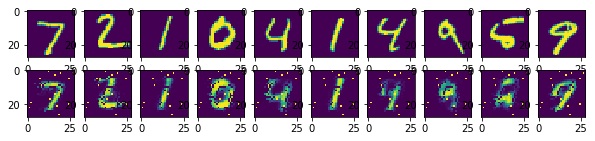

In [36]:
# Launch the graph
with tf.Session() as sess:
    init = tf.global_variables_initializer()
    sess.run(init)
    total_batch = int(mnist.train.num_examples / batch_size)
    # Training cycle
    for epoch in range(training_epochs):
        # Loop over all batches
        for i in range(total_batch):
            # mnist样本中的像素值已经归一化，max(x) = 1, min(x) = 0
            batch_xs, batch_ys = mnist.train.next_batch(batch_size)
            # Run optimization op (back prop) and cost op (to get loss value)
            _, c = sess.run([optimizer, cost], feed_dict = {X: batch_xs})
        # Display logs per epoch step
        if(epoch % display_step == 0):
            print('Epoch:', '%04d' % (epoch+1), 'cost =', '{:.9f}'.format(c))
    
    print('Optimization Finished!')
    
    # Applying encode and decode over test set
    encode_decode = sess.run(y_pred, feed_dict={X: mnist.test.images[:examples_to_show]})
    # Compare original image with their reconstructions
    f, a = plt.subplots(2, 10, figsize=(10, 2))
    for i in range(examples_to_show):
        a[0][i].imshow(np.reshape(mnist.test.images[i], (28, 28)))
        a[1][i].imshow(np.reshape(encode_decode[i], (28, 28)))
    plt.show()